In [1]:
import cv2
import csv
import numpy as np
import os

from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
import matplotlib.pyplot as plt
import sklearn



def readLineCSV(dataPath, skipHeader=True):
    
    lines = []
    with open(dataPath + '/driving_log.csv') as csvFile:
        reader = csv.reader(csvFile)
        if skipHeader:
            next(reader, None)
        for line in reader:
            lines.append(line)
    return lines


def readData(dataPath,correction):
    
    
    imagePaths = []
    measurements = []
    lines = readLineCSV(dataPath)
    for line in lines:
        measurements.append(float(line[3]))
        measurements.append(float(line[3])+correction)
        measurements.append(float(line[3])-correction)
        imagePaths.append(dataPath + '/' + line[0].strip())
        imagePaths.append(dataPath + '/' + line[1].strip())
        imagePaths.append(dataPath + '/' + line[2].strip())
    return (imagePaths, measurements)
    


def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        samples = sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for imagePath, measurement in batch_samples:
                originalImage = cv2.imread(imagePath)
                image = cv2.cvtColor(originalImage, cv2.COLOR_BGR2RGB)
                images.append(image)
                angles.append(measurement)
                # Flipping images to reduce the network inclination to steer either left or right because
                images.append(cv2.flip(image,1))
                angles.append(measurement*-1.0)

            # trim image to only see section with road
            inputs = np.array(images)
            outputs = np.array(angles)
            yield sklearn.utils.shuffle(inputs, outputs)




def nVidiaNet():
    model = Sequential()
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
    model.add(Cropping2D(cropping=((50,20), (0,0))))    
    model.add(Convolution2D(24,5,5, subsample=(2,2), activation='relu'))
    model.add(Convolution2D(36,5,5, subsample=(2,2), activation='relu'))
    model.add(Convolution2D(48,5,5, subsample=(2,2), activation='relu'))
    model.add(Convolution2D(64,3,3, activation='relu'))
    model.add(Convolution2D(64,3,3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dense(50))
    model.add(Dense(10))
    model.add(Dense(1))
    return model


# Reading images locations.
imagePaths, measurements = readData('data',0.2)
print('Total Images: {}'.format( len(imagePaths)))

# Splitting samples and creating generators.
from sklearn.model_selection import train_test_split
samples = list(zip(imagePaths, measurements))
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

print('Train samples: {}'.format(len(train_samples)))
print('Validation samples: {}'.format(len(validation_samples)))

train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

# init model
model = nVidiaNet()

# Compiling and training the model
model.compile(loss='mse', optimizer='adam')
trainLog = model.fit_generator(train_generator, samples_per_epoch= \
                 len(train_samples), validation_data=validation_generator, \
                 nb_val_samples=len(validation_samples), nb_epoch=3, verbose=1)

# save model
model.save('model.h5')

# Print training and validation loss 
print('Training Loss')
print(trainLog.history['loss'])
print('Validation Loss')
print(trainLog.history['val_loss'])

Using TensorFlow backend.


Total Images: 24108
Train samples: 19286
Validation samples: 4822
Epoch 1/3
19264/19286 [============================>.] - ETA: 0s - loss: 0.0206

C:\Users\Chaitanya\Anaconda3\envs\carnd-term1\lib\site-packages\keras\engine\training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


19328/19286 [==============================] - 351s - loss: 0.0206 - val_loss: 0.0155
Epoch 2/3
19308/19286 [==============================] - 337s - loss: 0.0167 - val_loss: 0.0157
Epoch 3/3
19328/19286 [==============================] - 358s - loss: 0.0157 - val_loss: 0.0145
Training Loss
[0.020625827397645409, 0.016675879634717668, 0.015700382860500784]
Validation Loss
[0.015528826337111624, 0.01574566136064311, 0.014459802683344796]


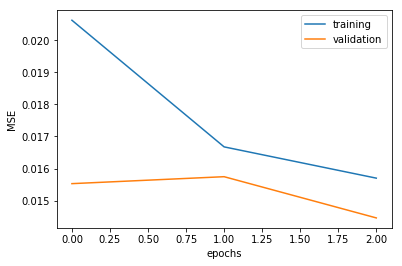

In [2]:
# Plots of learning curve 
plt.plot(trainLog.history['loss'])
plt.plot(trainLog.history['val_loss'])
plt.ylabel('MSE')
plt.xlabel('epochs')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()